In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf

data = pd.read_csv('processed_data.csv')

tfidf_vectorizer = TfidfVectorizer()

X_tfidf = tfidf_vectorizer.fit_transform(data['text']).toarray()

y = data['target'].astype(float).values.reshape(-1, 1)

print(f'Shape of X_tfidf: {X_tfidf.shape}')
print(f'Shape of y: {y.shape}')

2024-10-25 01:36:37.452738: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-25 01:36:38.677522: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Shape of X_tfidf: (7593, 6286)
Shape of y: (7593, 1)


In [2]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [3]:
X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_val_tf = tf.convert_to_tensor(X_val, dtype=tf.float32)
X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_val_tf = tf.convert_to_tensor(y_val, dtype=tf.float32)
y_test_tf = tf.convert_to_tensor(y_test, dtype=tf.float32)

print(f'Shape of X_train_tf: {X_train_tf.shape}')
print(f'Shape of y_train_tf: {y_train_tf.shape}')

2024-10-25 01:36:40.229539: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-25 01:36:40.288543: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-25 01:36:40.288676: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-25 01:36:40.292660: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-25 01:36:40.292752: I external/local_xla/xla/stream_executor

Shape of X_train_tf: (5315, 6286)
Shape of y_train_tf: (5315, 1)


In [4]:
from tensorflow.keras.layers import Dense, Dropout

model = tf.keras.Sequential([
    Dense(64, activation='relu', input_shape=(X_tfidf.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.summary()

/home/theotteryears/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │       402,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,481 (1.54 MB)

 Trainable params: 404,481 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

learning_rate = 0.00001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.000001)

history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_val_tf, y_val_tf),
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/500


2024-10-25 01:36:42.482708: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 133640360 exceeds 10% of free system memory.
2024-10-25 01:36:42.618399: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 133640360 exceeds 10% of free system memory.
I0000 00:00:1729795003.982416   47240 service.cc:145] XLA service 0x7f58d0009a10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729795003.982543   47240 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-10-25 01:36:44.019349: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-25 01:36:55.407611: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 33/167 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5100 - loss: 0.6925

I0000 00:00:1729795008.181659   47240 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


167/167 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.5224 - loss: 0.6925 - val_accuracy: 0.5601 - val_loss: 0.6919 - learning_rate: 1.0000e-05
Epoch 2/500
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5519 - loss: 0.6919 - val_accuracy: 0.5786 - val_loss: 0.6911 - learning_rate: 1.0000e-05
Epoch 3/500
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5830 - loss: 0.6909 - val_accuracy: 0.5803 - val_loss: 0.6903 - learning_rate: 1.0000e-05
Epoch 4/500
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5786 - loss: 0.6899 - val_accuracy: 0.5786 - val_loss: 0.6894 - learning_rate: 1.0000e-05
Epoch 5/500
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5796 - loss: 0.6887 - val_accuracy: 0.5742 - val_loss: 0.6885 - learning_rate: 1.0000e-05
Epoch 6/500
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5775 - loss: 0.6878 - val_accuracy: 0.5742 - val_loss: 0.6875 - learning_rate: 1.0000e-05
Epoch 7/500
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8139 - loss: 0.4461
Test Loss: 0.4556952714920044, Test Accuracy: 0.8059701323509216


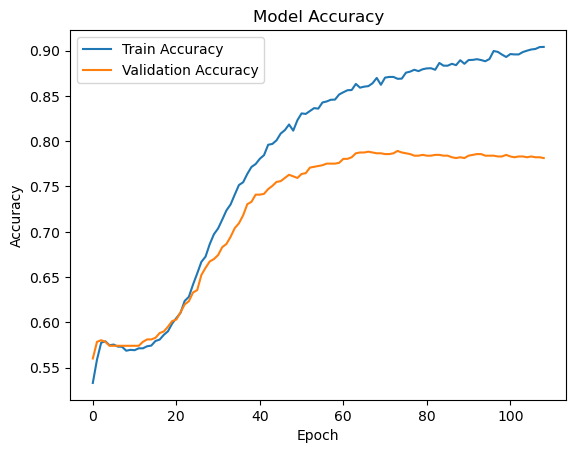

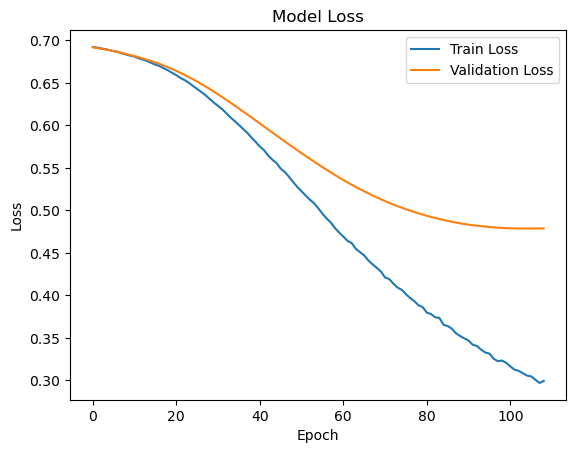

In [6]:
from matplotlib import pyplot as plt

loss, accuracy = model.evaluate(X_test_tf, y_test_tf)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [7]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = (model.predict(X_test) > 0.5).astype("int32")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s -312232us/step

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.88      0.84       666
         1.0       0.81      0.70      0.75       473

    accuracy                           0.81      1139
   macro avg       0.81      0.79      0.80      1139
weighted avg       0.81      0.81      0.80      1139


Confusion Matrix:
[[588  78]
 [143 330]]


In [8]:
model.save("tfidf.keras")